In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [3]:
query = """select * from mat_orders"""

df = pd.read_sql(query, con=conn_string)

In [4]:
cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    AND created_at < '2023-07-01'
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

<Axes: title={'center': 'Mean final price per operator distribution'}>

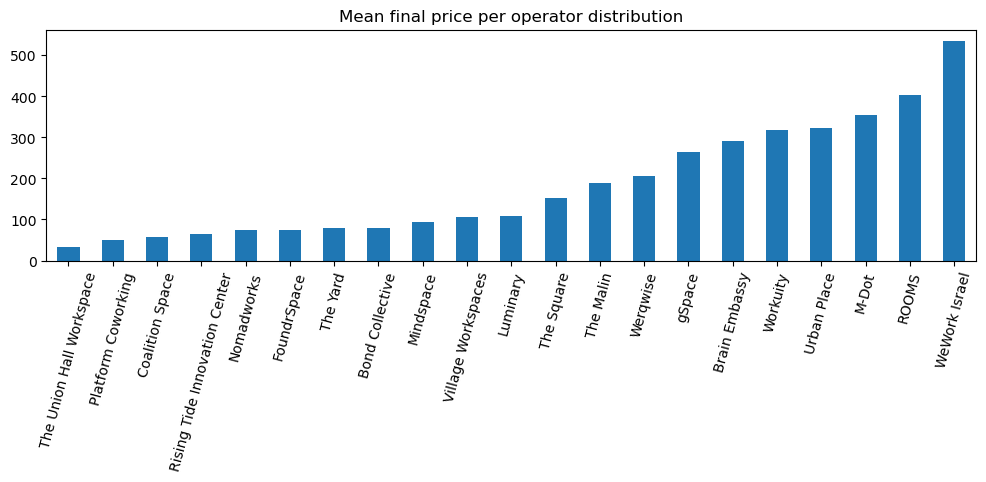

In [5]:
filtered_df.groupby('operator_name').mean(numeric_only=True)['final_price'].sort_values().plot(kind="bar", xlabel="", 
                                                                              rot=75,
                                                                              figsize=(12,3),
                                                                              title="Mean final price per operator distribution")

In [6]:
filtered_df.groupby('operator_name').sum(numeric_only=True)['final_price'].sort_values(ascending=False)


operator_name
WeWork Israel                    2279715.41
Mindspace                         862476.67
The Yard                          269103.00
The Malin                         256210.25
Urban Place                       201909.38
Brain Embassy                     176435.66
Werqwise                          115175.50
ROOMS                             105019.20
Luminary                           84839.75
Nomadworks                         69556.50
M-Dot                              35695.53
Bond Collective                    30043.75
FoundrSpace                        10972.50
Village Workspaces                  7271.60
gSpace                              1850.00
Rising Tide Innovation Center       1847.50
Workuity                             950.00
Platform Coworking                   815.00
The Square                           760.00
Coalition Space                      455.00
The Union Hall Workspace             395.00
Name: final_price, dtype: float64

In [7]:
# Extracting just the date from created_at as date
filtered_df['date'] = filtered_df['created_at'].dt.date

filtered_df['date'].count()


22695

In [8]:
# Number of unique operators
filtered_df['operator_id'].nunique()


21

In [9]:
fdf = filtered_df

# Features 

In [10]:
# Convert 'date' to a time stamp
fdf['date'] = pd.to_datetime(fdf['date'])

monetary_for_preperation = fdf.groupby(['operator_id', 'customer_email','date'], as_index=False)['final_price'].sum()
interim_fdf = fdf.sort_values(['operator_id', 'customer_email','created_at']).drop_duplicates(['operator_id', 'customer_email','date'])
interim_fdf = interim_fdf.drop('final_price', axis=1)

### Monetary value per country

In [11]:
fdf = interim_fdf.merge(monetary_for_preperation).copy()

In [13]:
country_totals = pd.DataFrame(fdf.groupby('country', as_index = False)['final_price_usd'].sum(numeric_only=True))

country_totals = country_totals.sort_values(by='final_price_usd', ascending=False).reset_index(drop=True)

country_totals


,country,final_price_usd
0,US,868369.54
1,IL,741107.85
2,DE,340773.58
3,GB,125481.03
4,NL,63256.89
5,PL,36958.07
6,RO,24499.01


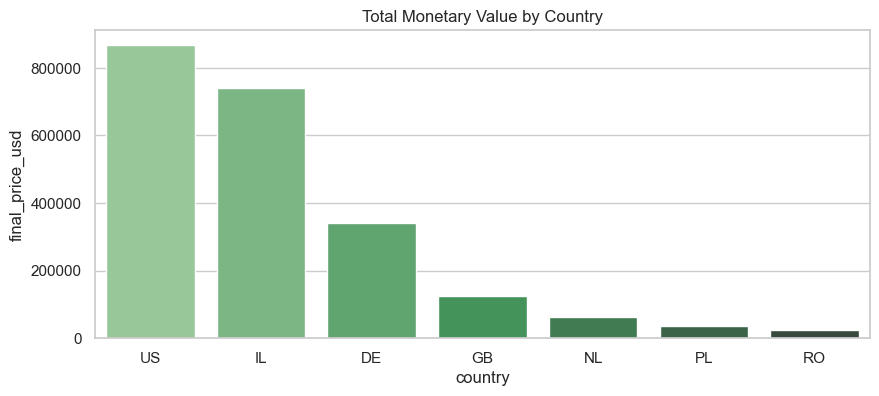

In [14]:
# Plotting country totals 
plt.figure(figsize=(10,4))

sns.set(style='whitegrid', color_codes=True)

pal = sns.color_palette('Greens_d', len(country_totals))

# Swap x and y for vertical bars
sns.barplot(x=country_totals['country'], y=country_totals['final_price_usd'], palette=pal)

plt.title('Total Monetary Value by Country')
plt.xticks()
plt.show()

### Number of operators in each country 

In [15]:
country_operator = pd.DataFrame(fdf.groupby('country', as_index = False)['operator_name'].nunique()).sort_values(by='operator_name', ascending=False).reset_index(drop=True)

country_operator 

,country,operator_name
0,US,16
1,IL,6
2,PL,2
3,DE,1
4,GB,1
5,NL,1
6,RO,1


Text(0.5, 1.0, 'Operators in each Country')

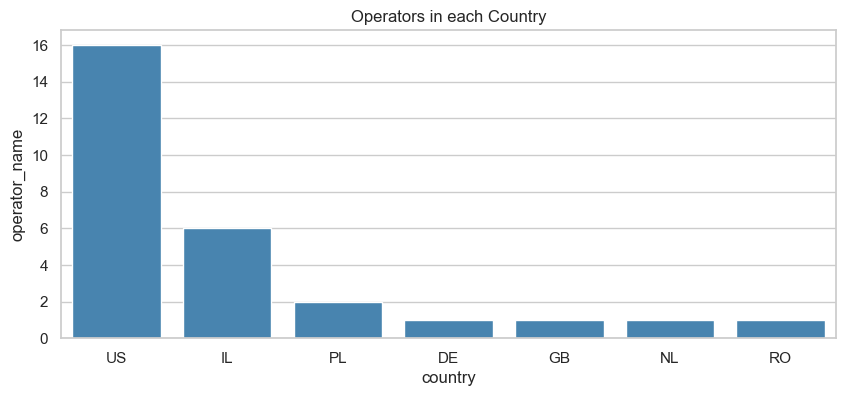

In [16]:
plt.figure(figsize = (10, 4))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues_d", 1)

sns.barplot(x=country_operator['country'], y=country_operator['operator_name'], palette=pal)

plt.title('Operators in each Country')

### Time series  

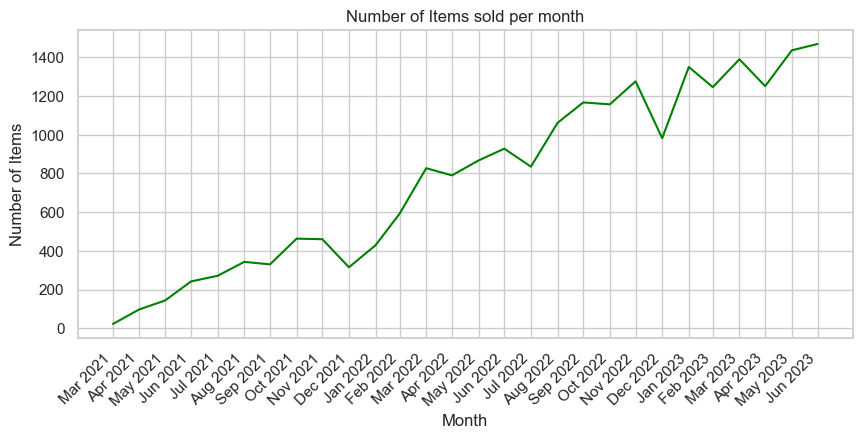

In [17]:
df_group = pd.DataFrame(fdf.resample('M', on='date')['order_id'].count())
df_group.columns = ['Number_of_items_sold']
    
plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group.index, y=df_group['Number_of_items_sold'], color = 'Green')

plt.title('Number of Items sold per month')
plt.xlabel('Month')
plt.ylabel('Number of Items')

plt.xticks(df_group.index, df_group.index.strftime('%b %Y'), rotation=45, ha='right')
plt.show()

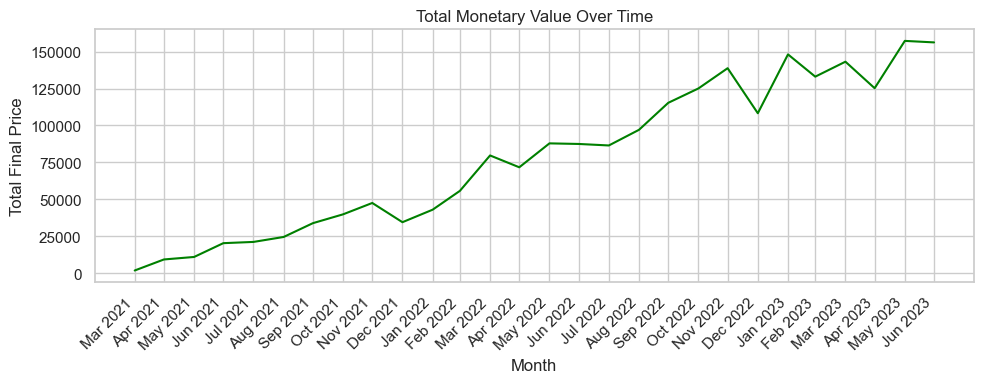

In [18]:
df_group = fdf.resample('M', on='date')['final_price_usd'].sum()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Total_final_price'], color = 'Green')

plt.title('Total Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

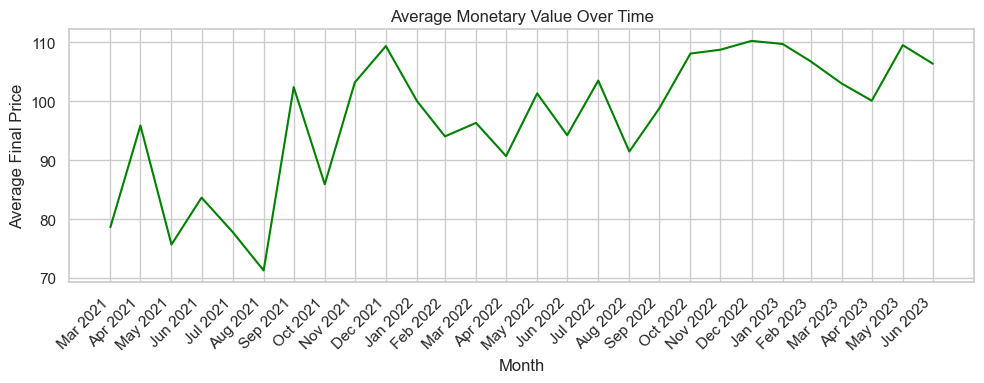

In [19]:
df_group = fdf.resample('M', on='date')['final_price_usd'].mean()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Average_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Average_final_price'], color = 'Green')

plt.title('Average Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Average Final Price')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

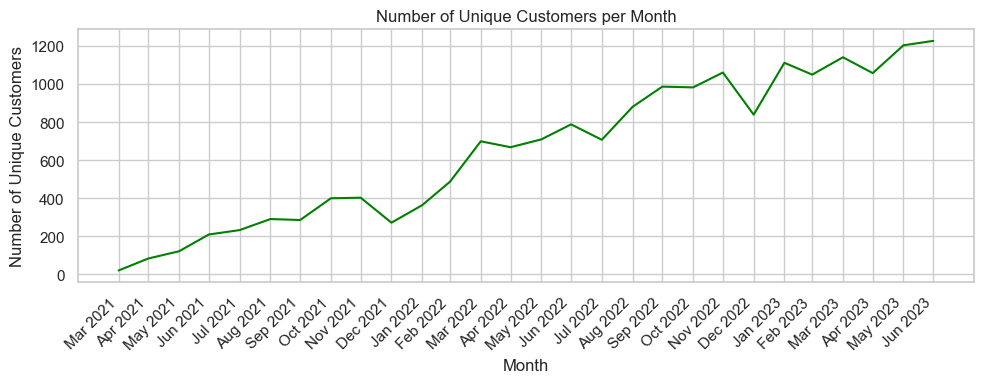

In [20]:
df_group = fdf.resample('M', on='date').customer_email.nunique()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Number_of_unique_customers']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Number_of_unique_customers'], color = 'Green')

plt.title('Number of Unique Customers per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Customers')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# RFM Function

In [21]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']

pivot_table = fdf.groupby(['operator_name', 'operator_key']).size().unstack(fill_value=0)

# pivot_table.astype(bool).sum(axis=1).sort_values(ascending=False)

In [24]:
def create_extended_rfm_by(fdf_, key="operator_name"):

    # this is a bogus filter - you can change that however you like
    fdf_filtered = fdf_[fdf_['date'] < pd.to_datetime('2023-07-01')].copy()
    
    #recency and lifetime
    df_recency = fdf_filtered.groupby(key)['date'].agg(["max", "min"]).reset_index()
    df_recency.columns = ['operator', 'last_order', "first_order"]
    
    df_recency['recency'] = (pd.Timestamp.now().normalize() - df_recency['last_order']).dt.days
    df_recency['lifetime'] = (df_recency['last_order'] - df_recency['first_order']).dt.days+1
    
    #monetary and frequency 
    df_monetary_freq = fdf_filtered.groupby(key)['final_price_usd'].agg(['count', sum]).copy().reset_index()
    df_monetary_freq.columns = ['operator', 'frequency', "monetary"]

    
    # Count number of orders for each customer and partner
    df_orders = fdf_filtered.groupby([key, 'customer_email']).size().reset_index(name='orders')
    # Calculate whether the customer has returned (1 if 'orders' > 1, 0 otherwise)
    df_orders['returned'] = (df_orders['orders'] > 1).astype(int)

    # Now group by partner_name and calculate total customers and returning customers
    df_final = df_orders.groupby(key).agg(total_customers=('customer_email', 'count'), returning_customers=('returned', 'sum')).reset_index()
    df_final['return_rate'] = df_final['returning_customers'] / df_final['total_customers']
    #df_final = df_final.drop(['returning_customers', 'total_customers'], axis=1).copy()
    df_final.columns = ['operator', "total_customers", "returning_customers", "return_rate"]
    
    df = df_recency.merge(df_monetary_freq).merge(df_final).copy()
    df = df.drop(['last_order','first_order','returning_customers'], axis=1)
    df['intensity'] = df['frequency']/df['lifetime']
    return df

In [25]:
rfm_by_operator_name = create_extended_rfm_by(fdf)
rfm_by_full_name = create_extended_rfm_by(fdf, key="operator_full_name")

In [26]:
rfm_by_full_name.head()

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
0,Bond Collective-US-CA-Los Angeles,43,85,21,1362.50,20,0.050000,0.247059
1,Bond Collective-US-DC-Washington,114,9,5,125.00,3,0.666667,0.555556
2,Bond Collective-US-IL-Chicago,40,91,46,5650.00,43,0.069767,0.505495
3,Bond Collective-US-NY-Brooklyn,40,89,173,9650.00,136,0.198529,1.943820
4,Bond Collective-US-NY-New York,41,80,59,4143.75,49,0.142857,0.737500


In [27]:
rfm_by_full_name.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,46.983871,446.338710,350.532258,35491.064032,234.548387,0.204471,0.700055
std,17.701988,297.078669,523.993891,55092.449542,344.163832,0.111133,0.797633
min,40.000000,1.000000,1.000000,125.000000,1.000000,0.000000,0.036232
25%,40.000000,140.250000,34.500000,3759.322500,25.250000,0.154600,0.237086
50%,41.000000,488.500000,142.000000,11180.080000,94.500000,0.198697,0.381385
75%,43.000000,706.250000,453.750000,39026.847500,327.750000,0.249282,0.843671
max,138.000000,842.000000,2451.000000,312877.810000,1658.000000,0.666667,4.339552


# Segmentation

In [28]:
def segment_customer(row):
    if row['lifetime'] < 90:
        return 'new'
    elif row['recency'] > 45:
        return 'churned'
    elif row['lifetime'] < 400 and row['monetary'] < 100000:
        return 'not_blooming'
    elif row['lifetime'] >= 400 and row['monetary'] < 100000:
        return 'loyalist'
    elif row['monetary'] >= 100000:
        return 'big_fish'
    else:
        return 'other'

rfm_by_full_name['seg'] = rfm_by_full_name.apply(segment_customer, axis=1)

In [29]:
rfm_by_full_name['seg'].unique()

array(['new', 'not_blooming', 'loyalist', 'churned', 'big_fish'],
      dtype=object)

In [30]:
rfm_by_full_name['seg'].value_counts(sort=False)

new             13
not_blooming     9
loyalist        26
churned          8
big_fish         6
Name: seg, dtype: int64

In [31]:
seg_merge_fdf = fdf.merge(rfm_by_full_name[['operator', 'seg']], 
                       left_on='operator_full_name', 
                       right_on='operator')


In [32]:
big_fish_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'big_fish']
loyalist_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'loyalist']
not_blooming_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'not_blooming']
new_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'new']
churned_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'churned']


In [33]:
big_fish_monetary = big_fish_fdf[['date', 'final_price_usd']]
loyalist_monetary = loyalist_fdf[['date', 'final_price_usd']]
not_blooming_monetary = not_blooming_fdf[['date', 'final_price_usd']]


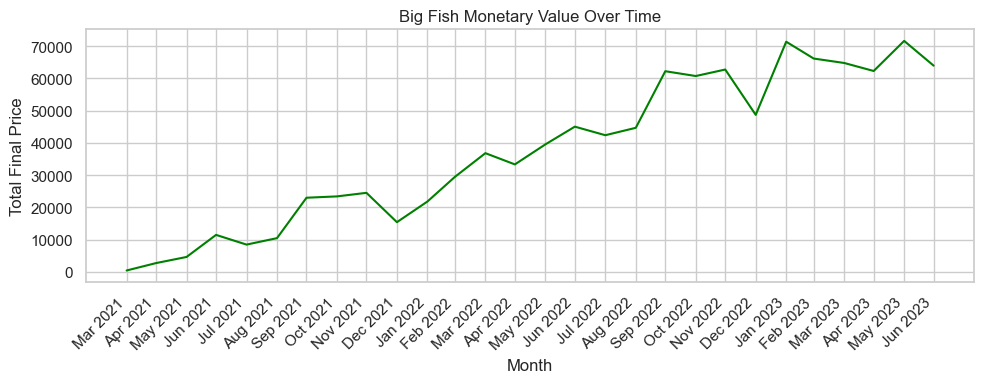

In [34]:
big_fish_monetary = big_fish_monetary.resample('M', on='date')['final_price_usd'].sum()
big_fish_monetary = big_fish_monetary.reset_index()
big_fish_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=big_fish_monetary['Month'], y=big_fish_monetary['Total_final_price'], color = 'Green')

plt.title('Big Fish Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(big_fish_monetary['Month'], big_fish_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

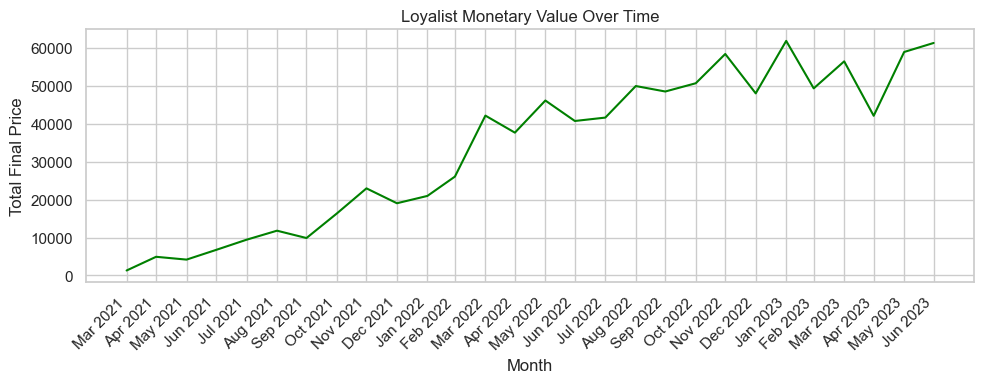

In [35]:
loyalist_monetary = loyalist_monetary.resample('M', on='date')['final_price_usd'].sum()
loyalist_monetary = loyalist_monetary.reset_index()
loyalist_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=loyalist_monetary['Month'], y=loyalist_monetary['Total_final_price'], color = 'Green')

plt.title('Loyalist Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(loyalist_monetary['Month'], loyalist_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

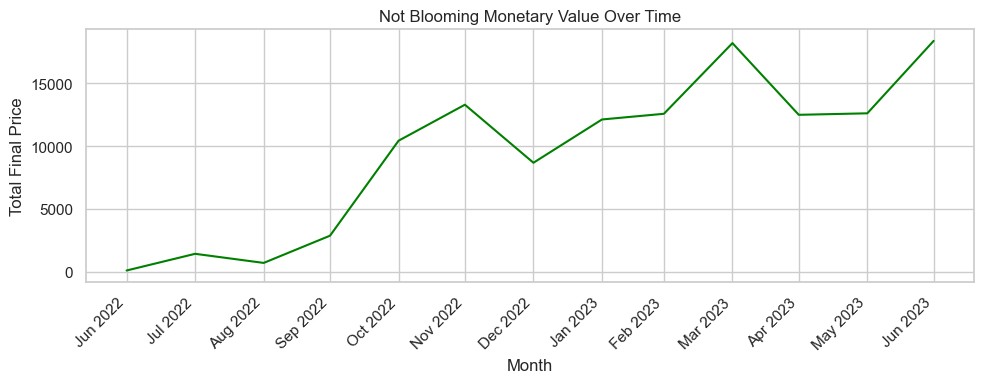

In [36]:
not_blooming_monetary = not_blooming_monetary.resample('M', on='date')['final_price_usd'].sum()
not_blooming_monetary = not_blooming_monetary.reset_index()
not_blooming_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=not_blooming_monetary['Month'], y=not_blooming_monetary['Total_final_price'], color = 'Green')

plt.title('Not Blooming Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(not_blooming_monetary['Month'], not_blooming_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

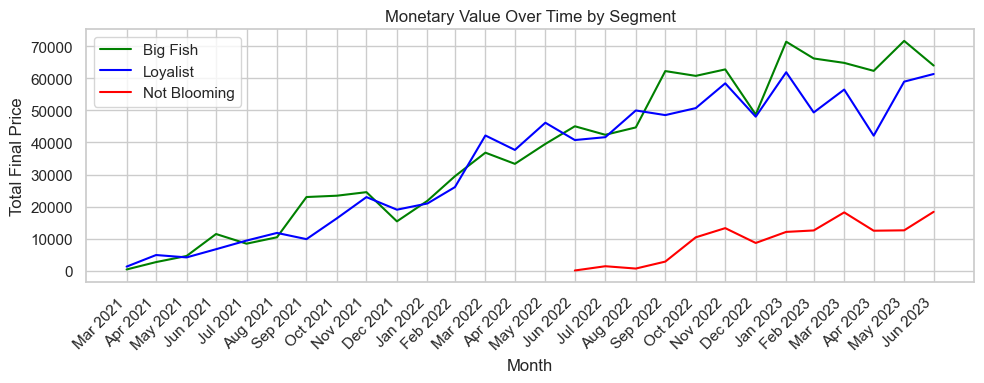

In [37]:
plt.figure(figsize=(10, 4))

sns.lineplot(x=big_fish_monetary['Month'], y=big_fish_monetary['Total_final_price'], label='Big Fish', color='Green')

sns.lineplot(x=loyalist_monetary['Month'], y=loyalist_monetary['Total_final_price'], label='Loyalist', color='Blue')

sns.lineplot(x=not_blooming_monetary['Month'], y=not_blooming_monetary['Total_final_price'], label='Not Blooming', color='Red')

plt.title('Monetary Value Over Time by Segment')
plt.xlabel('Month')
plt.ylabel('Total Final Price')
plt.xticks(big_fish_monetary['Month'], big_fish_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
big_fish_frequency = big_fish_fdf[['date', 'operator_full_name']]
loyalist_frequency = loyalist_fdf[['date', 'operator_full_name']]
not_blooming_frequency = not_blooming_fdf[['date', 'operator_full_name']]

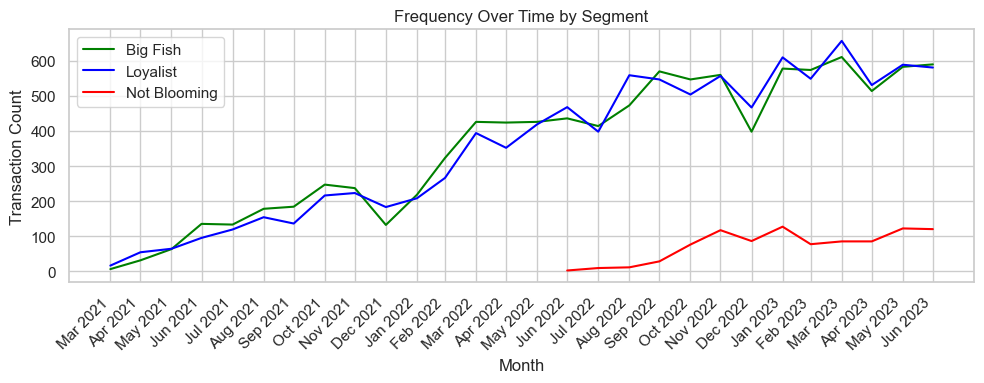

In [40]:
big_fish_freq = big_fish_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')
loyalist_freq = loyalist_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')
not_blooming_freq = not_blooming_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')

# Set up the figure and axis
plt.figure(figsize=(10, 4))

# Big Fish segment frequency
sns.lineplot(x=big_fish_freq['date'], y=big_fish_freq['Frequency'], label='Big Fish', color='Green')

# Loyalist segment frequency
sns.lineplot(x=loyalist_freq['date'], y=loyalist_freq['Frequency'], label='Loyalist', color='Blue')

# Not Blooming segment frequency
sns.lineplot(x=not_blooming_freq['date'], y=not_blooming_freq['Frequency'], label='Not Blooming', color='Red')

# Set the chart title, axis labels, and other aesthetics
plt.title('Frequency Over Time by Segment')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.xticks(big_fish_freq['date'], big_fish_freq['date'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.legend()  # Display the legend
plt.tight_layout()
plt.show()


In [47]:
def filter_by_segments(df, segments=["new", "churned", "big_fish", "loyalist", "not_blooming"]):
    segment_dataframes = {}
    for segment in segments:
        segment_dataframes[segment] = df[df['seg'] == segment].copy()
    return segment_dataframes

segmented_rfms = filter_by_segments(rfm_by_full_name)

new_rfm = segmented_rfms['new']
churned_rfm = segmented_rfms['churned']
big_fish_rfm = segmented_rfms['big_fish']
loyalist_rfm = segmented_rfms['loyalist']
not_blooming_rfm = segmented_rfms['not_blooming']


In [48]:
from sklearn.preprocessing import MinMaxScaler

metrics = ['recency','lifetime', 'frequency', 'monetary', 'total_customers', 'return_rate', 'intensity']

# Normalize the data
scaler = MinMaxScaler()
new_rfm_normalized = pd.DataFrame(scaler.fit_transform(new_rfm[metrics]), columns=metrics)
churned_rfm_normalized = pd.DataFrame(scaler.fit_transform(churned_rfm[metrics]), columns=metrics)
big_fish_rfm_normalized = pd.DataFrame(scaler.fit_transform(big_fish_rfm[metrics]), columns=metrics)
loyalist_rfm_normalized = pd.DataFrame(scaler.fit_transform(loyalist_rfm[metrics]), columns=metrics)
not_blooming_rfm_normalized = pd.DataFrame(scaler.fit_transform(not_blooming_rfm[metrics]), columns=metrics)

# Calculate means
new_mean = new_rfm_normalized.mean()
churned_mean = churned_rfm_normalized.mean()
big_fish_mean = big_fish_rfm_normalized.mean()
loyalist_mean = loyalist_rfm_normalized.mean()
not_blooming_mean = not_blooming_rfm_normalized.mean()

In [49]:
df_means = pd.DataFrame({
    'segment': ['new', 'churned', 'big_fish', 'loyalists', 'not_blooming'],
    'recency': [new_mean['recency'], churned_mean['recency'], big_fish_mean['recency'], loyalist_mean['recency'], not_blooming_mean['recency']],
    'lifetime': [new_mean['lifetime'], churned_mean['lifetime'], big_fish_mean['lifetime'], loyalist_mean['lifetime'], not_blooming_mean['lifetime']],
    'frequency': [new_mean['frequency'], churned_mean['frequency'], big_fish_mean['frequency'], loyalist_mean['frequency'], not_blooming_mean['frequency']],
    'monetary': [new_mean['monetary'], churned_mean['monetary'], big_fish_mean['monetary'], loyalist_mean['monetary'], not_blooming_mean['monetary']],
    'total_customers': [new_mean['total_customers'], churned_mean['total_customers'], big_fish_mean['total_customers'], loyalist_mean['total_customers'], not_blooming_mean['total_customers']],
    'return_rate': [new_mean['return_rate'], churned_mean['return_rate'], big_fish_mean['return_rate'], loyalist_mean['return_rate'], not_blooming_mean['return_rate']],
    'intensity': [new_mean['intensity'], churned_mean['intensity'], big_fish_mean['intensity'], loyalist_mean['intensity'], not_blooming_mean['intensity']]
})

In [50]:
# Metrics and segments
metrics = ['recency', 'lifetime', 'frequency', 'monetary', 'total_customers', 'return_rate', 'intensity']
segments = ['new', 'churned', 'big_fish', 'loyalist', 'not_blooming']

# Normalize the data
scaler = MinMaxScaler()
rfm_by_full_name_normalized = pd.DataFrame(scaler.fit_transform(rfm_by_full_name[metrics]), columns=metrics)

# Add the 'seg' column back to the normalized dataframe so you can group by it
rfm_by_full_name_normalized['seg'] = rfm_by_full_name['seg']

# Group by the 'seg' column and calculate mean for each group
segment_means = rfm_by_full_name_normalized.groupby('seg').mean()

# Filter to just the segments of interest (in case there are other segments in the 'seg' column)
segment_means = segment_means.loc[segments]



In [51]:
segment_means

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
seg,,,,,,,
new,0.133438,0.058447,0.010895,0.006125,0.013184,0.323553,0.132080
churned,0.276786,0.443817,0.025153,0.019865,0.030175,0.227498,0.034506
big_fish,0.001701,0.818866,0.680612,0.560149,0.637900,0.361962,0.573132
loyalist,0.011381,0.800878,0.155259,0.116116,0.157444,0.327257,0.129469
not_blooming,0.018141,0.309420,0.042449,0.043611,0.044994,0.256580,0.085106


In [53]:
rfm_means = segment_means.reset_index()


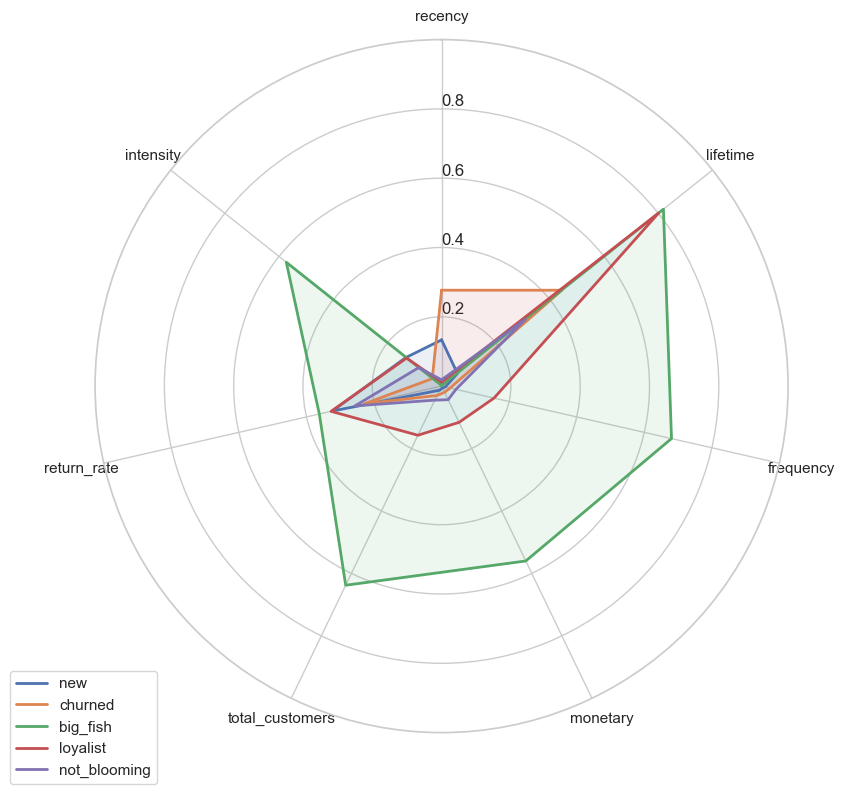

In [55]:
from math import pi

# number of variables
categories = metrics
N = len(categories)

# angles for the radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# setup the radar chart
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)


# set labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
yticks = [0.2, 0.4, 0.6, 0.8]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=12)
plt.ylim(0, 1)


# Plotting the data
colors = ['b', 'r', 'g', 'c', 'm']

for i, color in zip(rfm_means.index, colors):
    values = rfm_means.loc[i].drop('seg').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=rfm_means['seg'][i])
    ax.fill(angles, values, color, alpha=0.1)

# add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


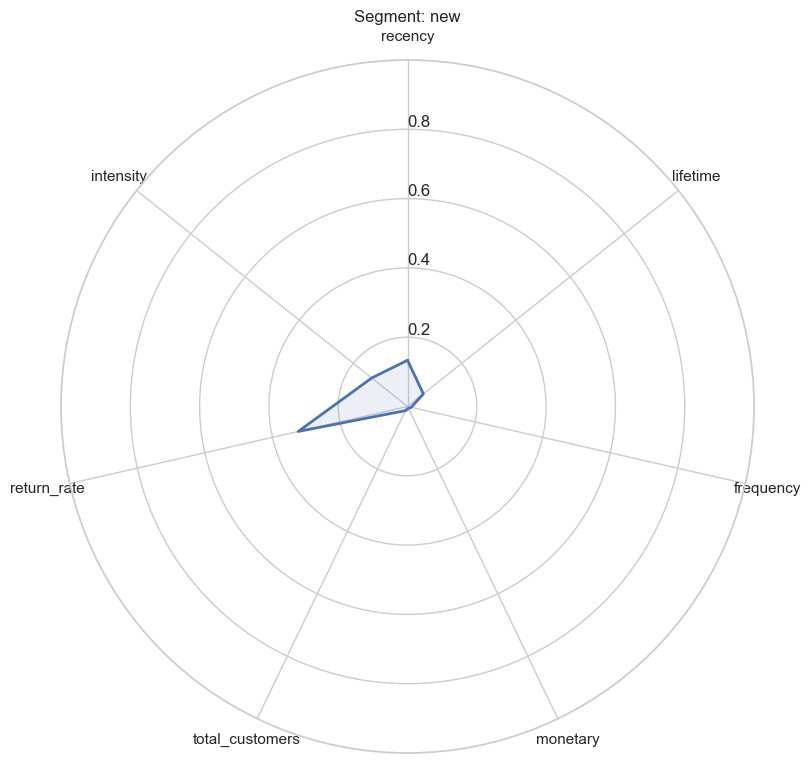

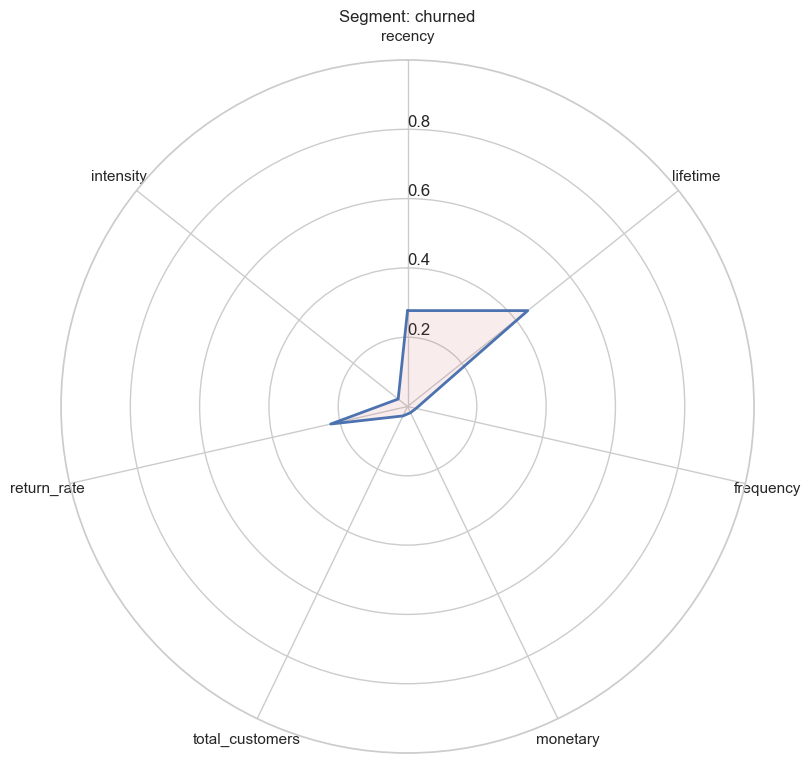

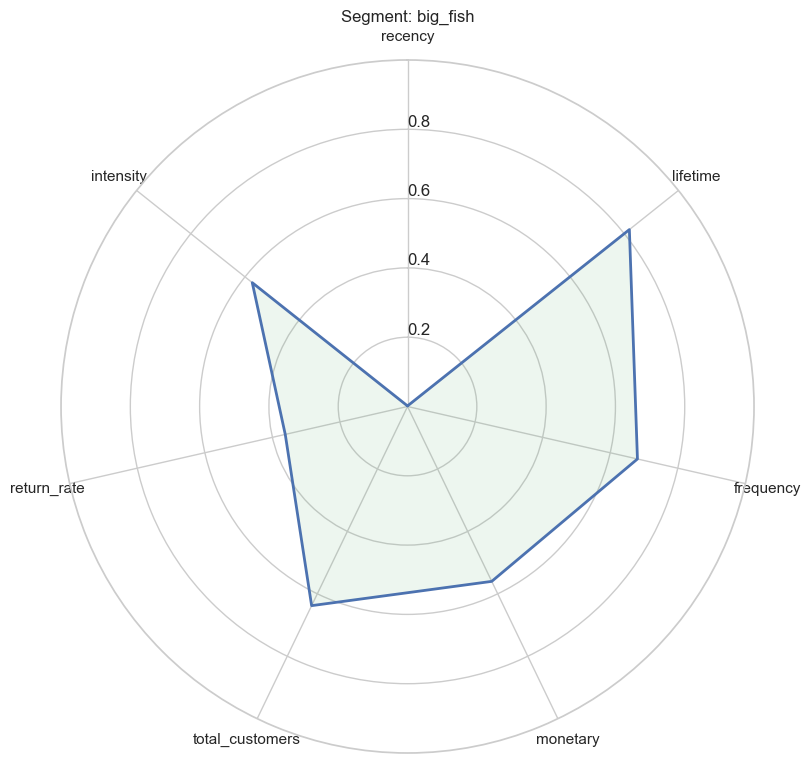

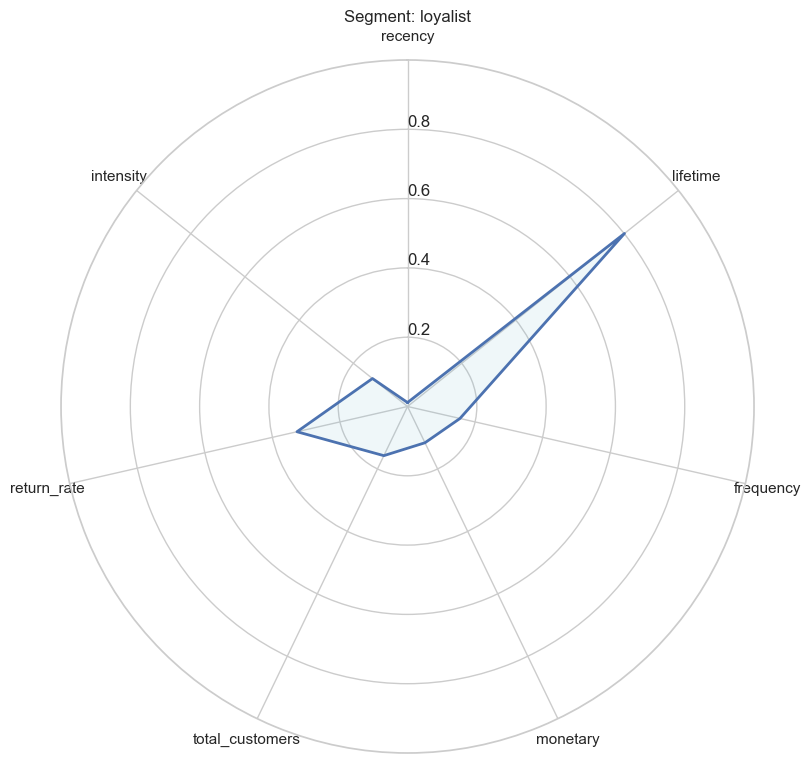

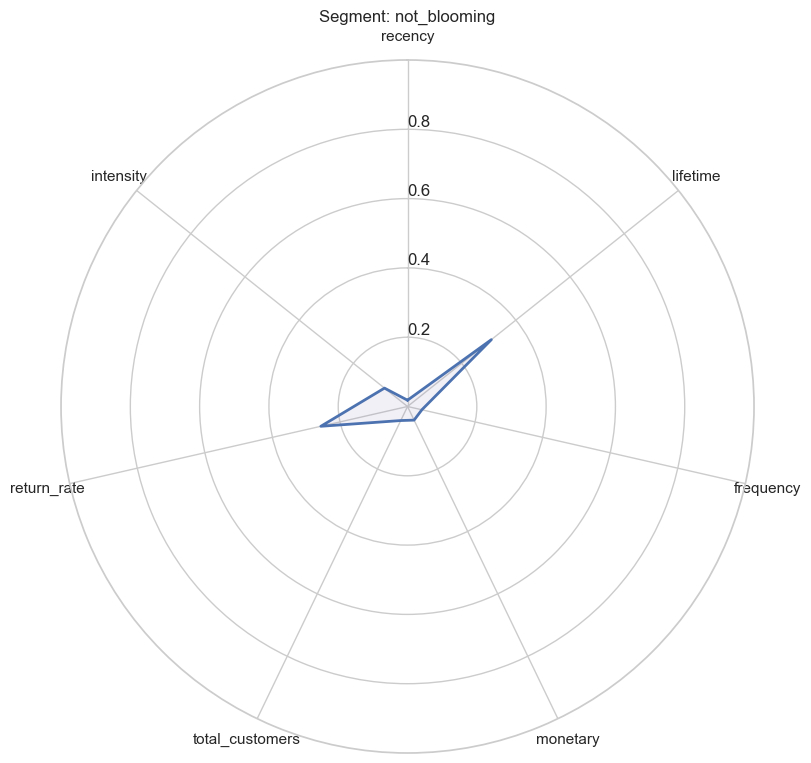

In [56]:
# number of variables
categories = metrics
N = len(categories)

# angles for the radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Setup the radar chart settings
fig_size = (9, 9)

# Initialize yticks for the radar chart
yticks = [0.2, 0.4, 0.6, 0.8]

colors = ['b', 'r', 'g', 'c', 'm']

for i, color in zip(rfm_means.index, colors):
    fig, ax = plt.subplots(figsize=fig_size, subplot_kw=dict(polar=True))
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(y) for y in yticks], fontsize=12)
    plt.ylim(0, 1)
    
    # Plotting the data for the specific segment
    values = rfm_means.loc[i].drop('seg').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=rfm_means['seg'][i])
    ax.fill(angles, values, color, alpha=0.1)
    
    # Title
    plt.title(f"Segment: {rfm_means['seg'][i]}")
    
    # Show the graph
    plt.show()


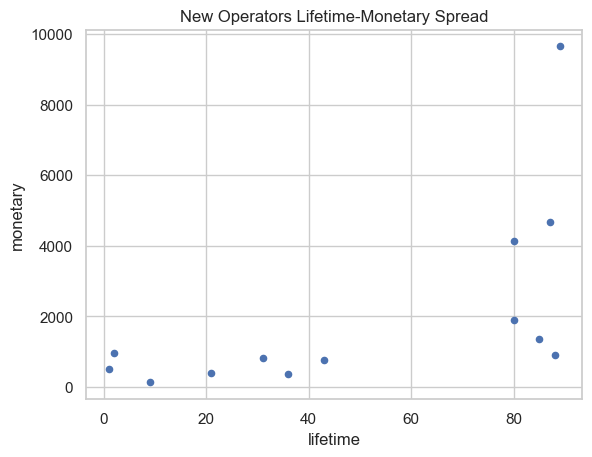

In [57]:
new_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "New Operators Lifetime-Monetary Spread");
                                                     

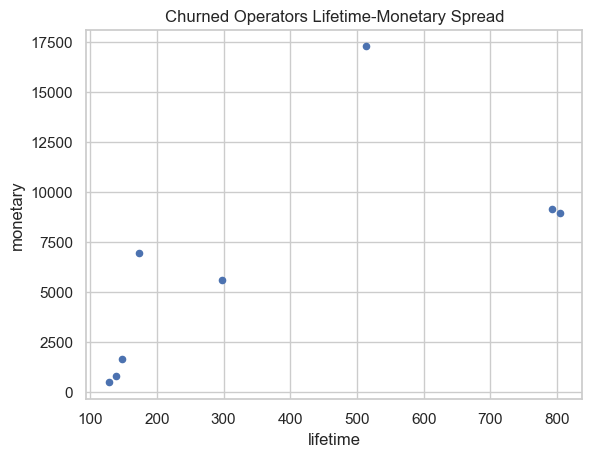

In [58]:
churned_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Churned Operators Lifetime-Monetary Spread");


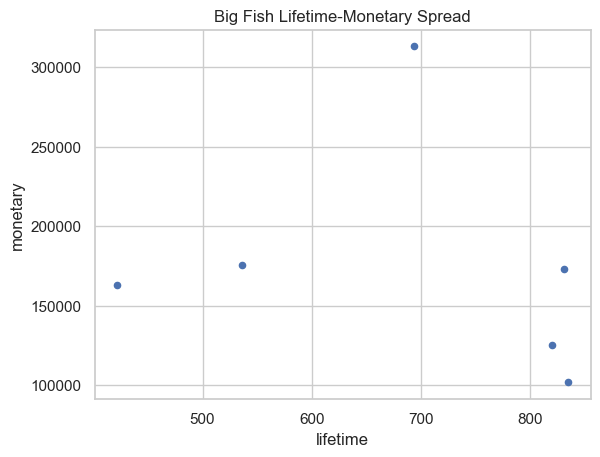

In [59]:
big_fish_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Big Fish Lifetime-Monetary Spread");


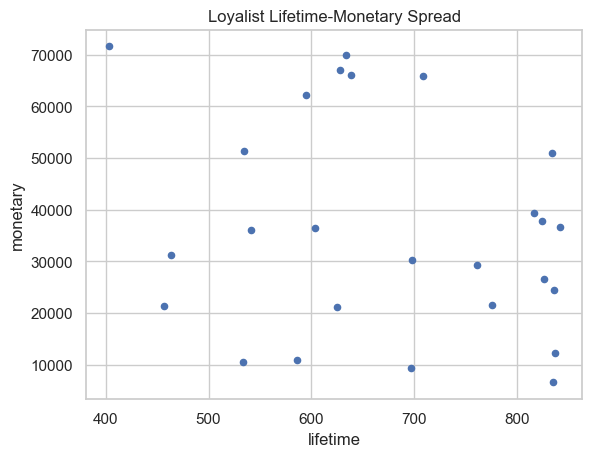

In [60]:
loyalist_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Loyalist Lifetime-Monetary Spread");


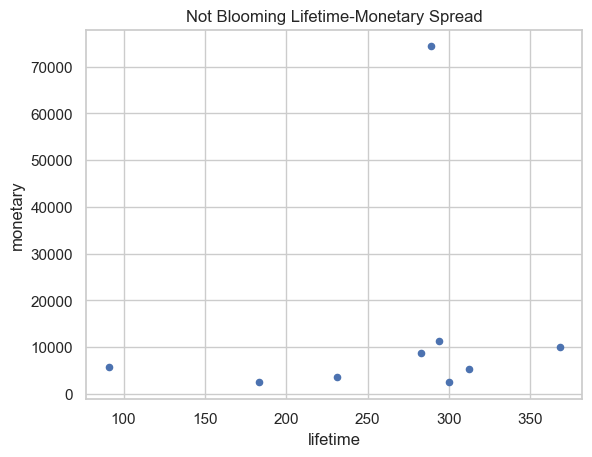

In [61]:
not_blooming_rfm[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Not Blooming Lifetime-Monetary Spread");


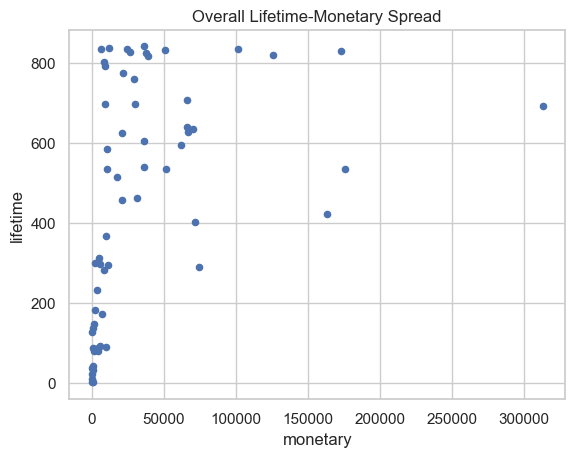

In [62]:
rfm_by_full_name[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "Overall Lifetime-Monetary Spread");


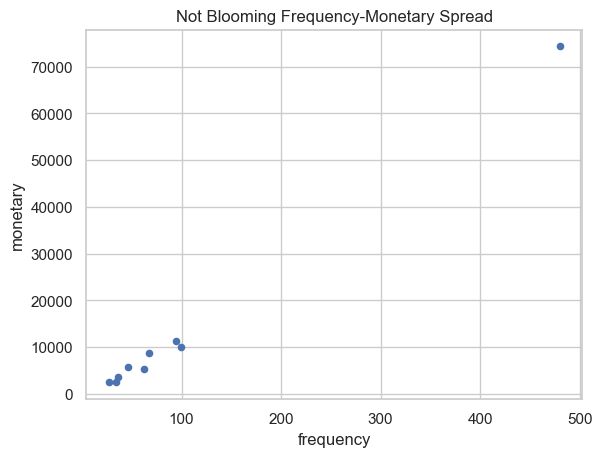

In [63]:
not_blooming_rfm[['frequency', 'monetary']].plot(kind='scatter', x='frequency', y='monetary', title = "Not Blooming Frequency-Monetary Spread");


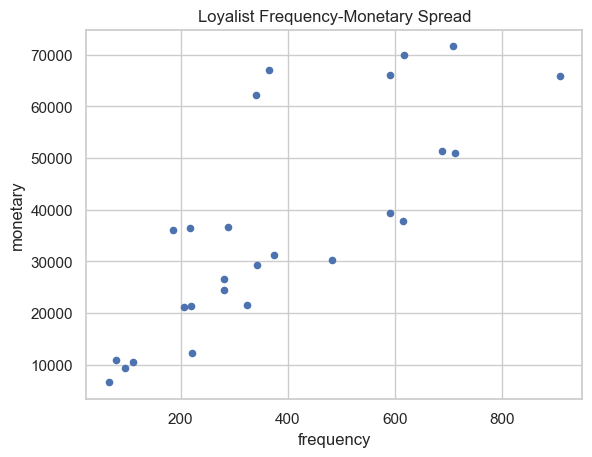

In [64]:
loyalist_rfm[['frequency', 'monetary']].plot(kind='scatter', x='frequency', y='monetary', title = "Loyalist Frequency-Monetary Spread");


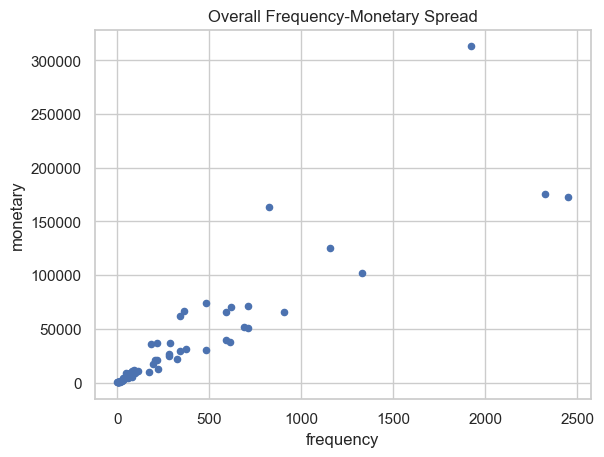

In [65]:
rfm_by_full_name[['frequency', 'monetary']].plot(kind='scatter', x='frequency', y='monetary', title = "Overall Frequency-Monetary Spread");


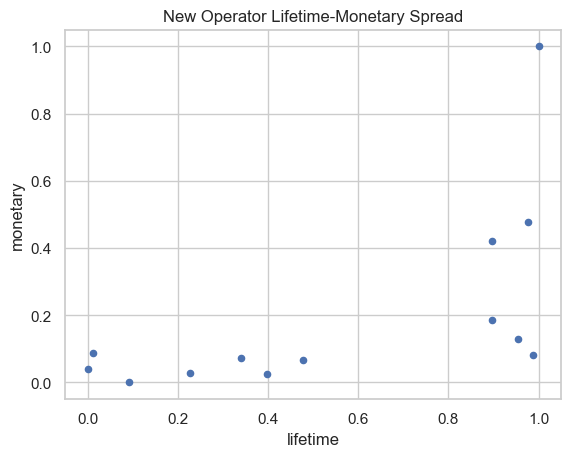

In [66]:
new_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "New Operator Lifetime-Monetary Spread");


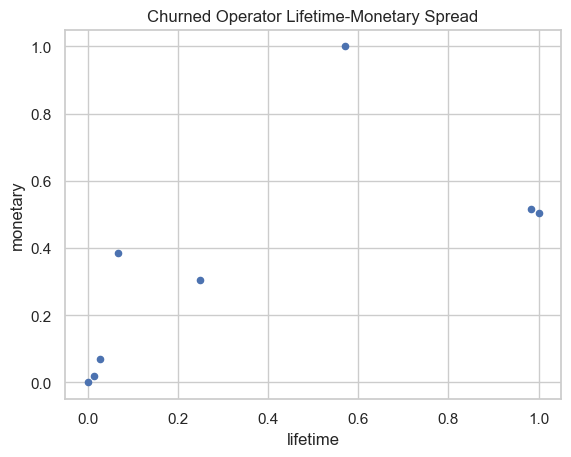

In [67]:
churned_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Churned Operator Lifetime-Monetary Spread");


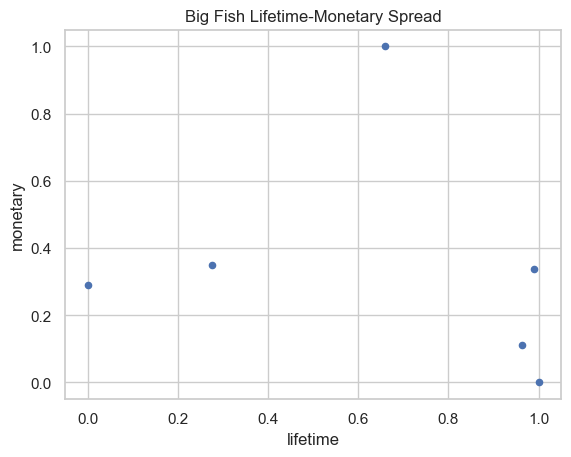

In [68]:
big_fish_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Big Fish Lifetime-Monetary Spread");


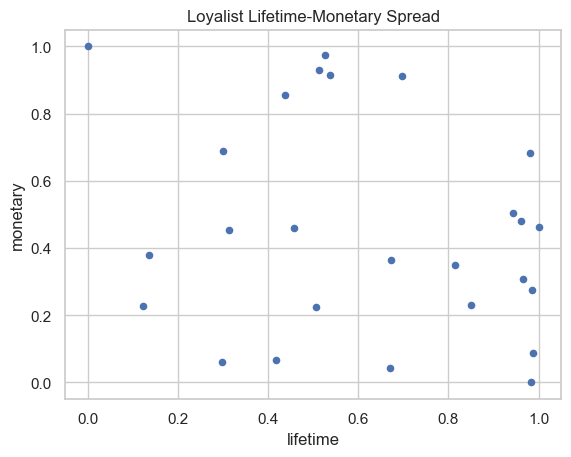

In [69]:
loyalist_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Loyalist Lifetime-Monetary Spread");


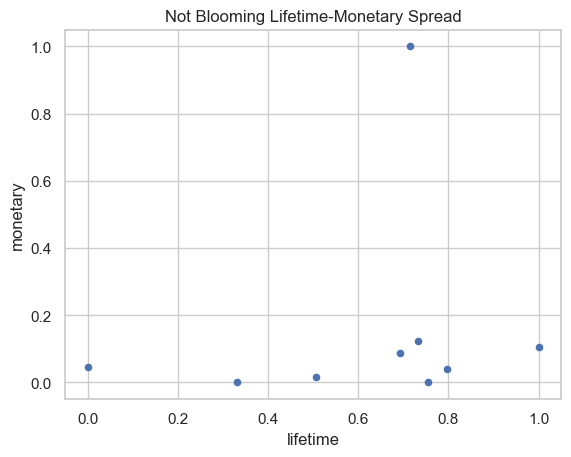

In [70]:
not_blooming_rfm_normalized[['lifetime', 'monetary']].plot(kind='scatter', x='lifetime', y='monetary', title = "Not Blooming Lifetime-Monetary Spread");


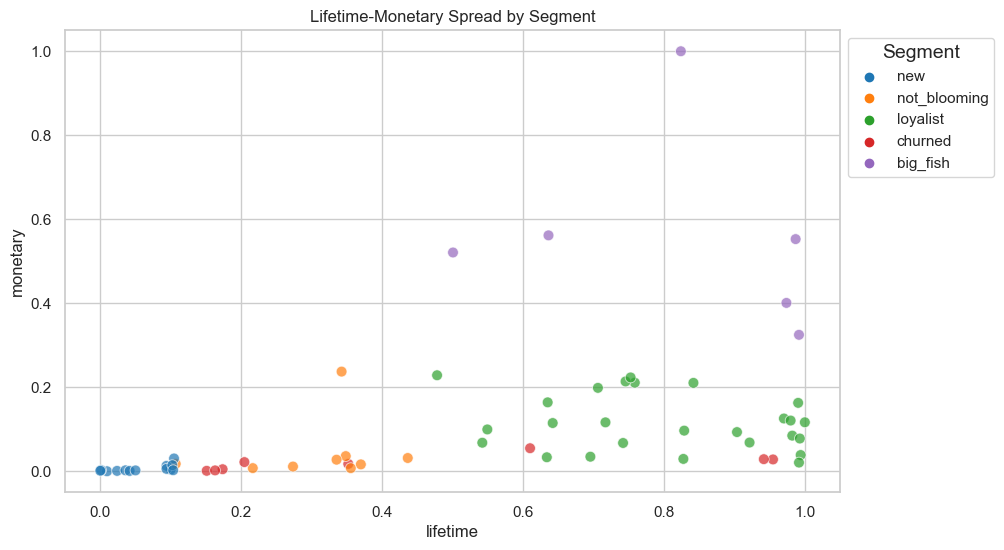

In [71]:

plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=rfm_by_full_name_normalized, x='lifetime', y='monetary', hue='seg', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Lifetime-Monetary Spread by Segment")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment')  
legend.get_title().set_fontsize('14')  

plt.show()


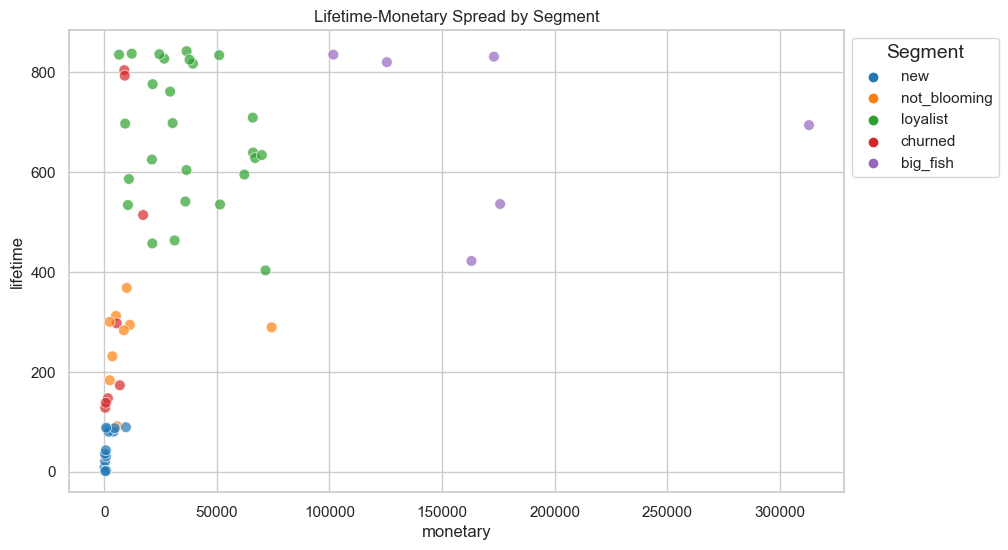

In [72]:

plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=rfm_by_full_name, x='monetary', y='lifetime', hue='seg', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Lifetime-Monetary Spread by Segment")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment')  # Move legend to the left
legend.get_title().set_fontsize('14')  

plt.show()

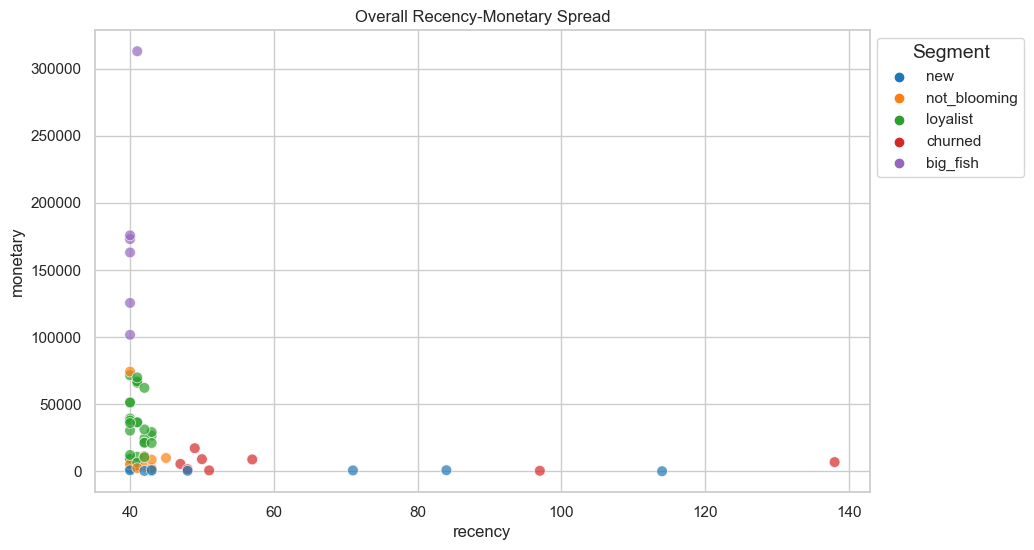

In [73]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=rfm_by_full_name, x='recency', y='monetary', hue='seg', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Overall Recency-Monetary Spread")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment') 
legend.get_title().set_fontsize('14')  

plt.show()

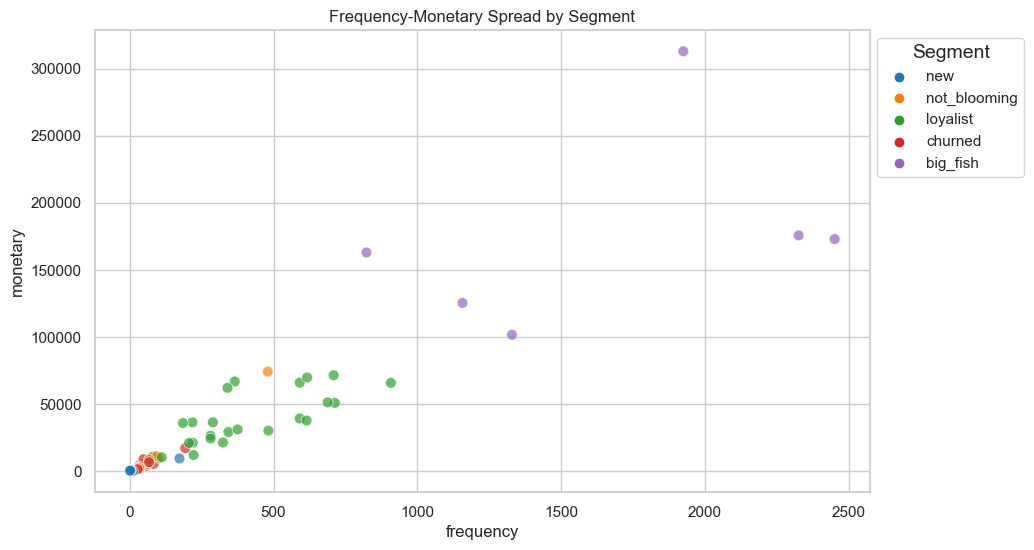

In [74]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=rfm_by_full_name, x='frequency', y='monetary', hue='seg', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Frequency-Monetary Spread by Segment")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment') 
legend.get_title().set_fontsize('14')  

plt.show()

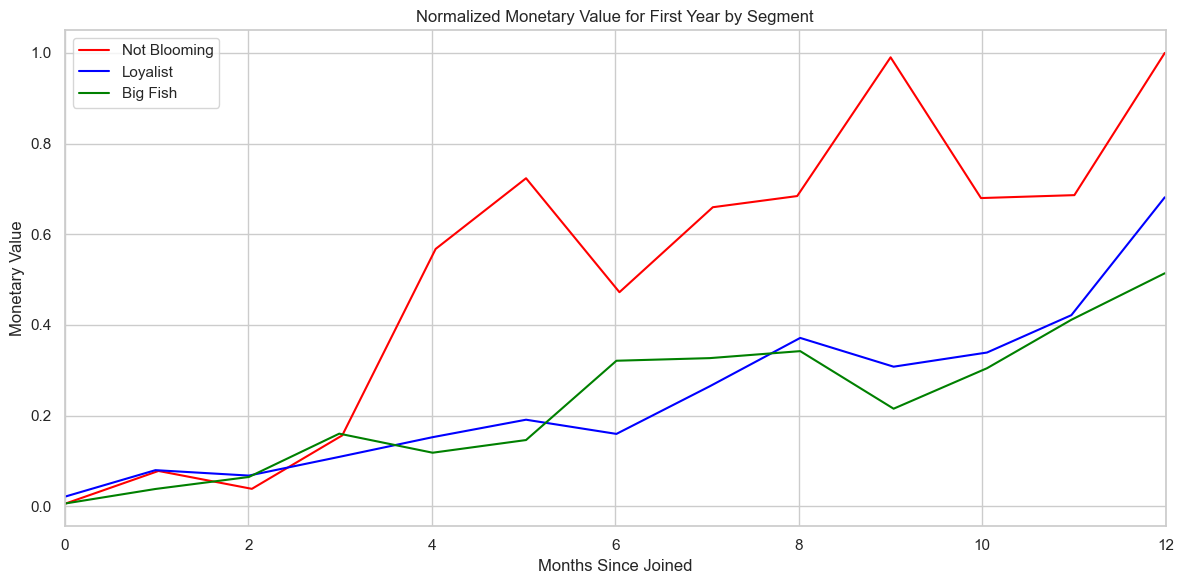

In [75]:
def preprocess(df, base_date):
    df['Month'] = pd.to_datetime(df['Month'])
    df['Months_Since_Joined'] = (df['Month'] - pd.to_datetime(base_date)) / np.timedelta64(1, 'M')
    max_monetary_value = df['Total_final_price'].max()
    df['Normalized_Monetary'] = df['Total_final_price'] / max_monetary_value
    return df

not_blooming_monetary = preprocess(not_blooming_monetary, '2022-06-30')
loyalist_monetary = preprocess(loyalist_monetary, '2021-03-31')
big_fish_monetary = preprocess(big_fish_monetary, '2021-03-31')

# Plotting
plt.figure(figsize=(12, 6))

sns.lineplot(x=not_blooming_monetary['Months_Since_Joined'], y=not_blooming_monetary['Normalized_Monetary'], color='Red', label='Not Blooming')
sns.lineplot(x=loyalist_monetary['Months_Since_Joined'], y=loyalist_monetary['Normalized_Monetary'], color='Blue', label='Loyalist')
sns.lineplot(x=big_fish_monetary['Months_Since_Joined'], y=big_fish_monetary['Normalized_Monetary'], color='Green', label='Big Fish')

#sns.lineplot(x=not_blooming_monetary['Months_Since_Joined'], y=not_blooming_monetary['Total_final_price'], color='Red', label='Not Blooming')
#sns.lineplot(x=loyalist_monetary['Months_Since_Joined'], y=loyalist_monetary['Total_final_price'], color='Blue', label='Loyalist')
#sns.lineplot(x=big_fish_monetary['Months_Since_Joined'], y=big_fish_monetary['Total_final_price'], color='Green', label='Big Fish')


plt.title('Normalized Monetary Value for First Year by Segment')
plt.xlabel('Months Since Joined')
plt.ylabel('Monetary Value')
plt.xlim(0, 12) 
plt.tight_layout()
plt.legend()
plt.show()

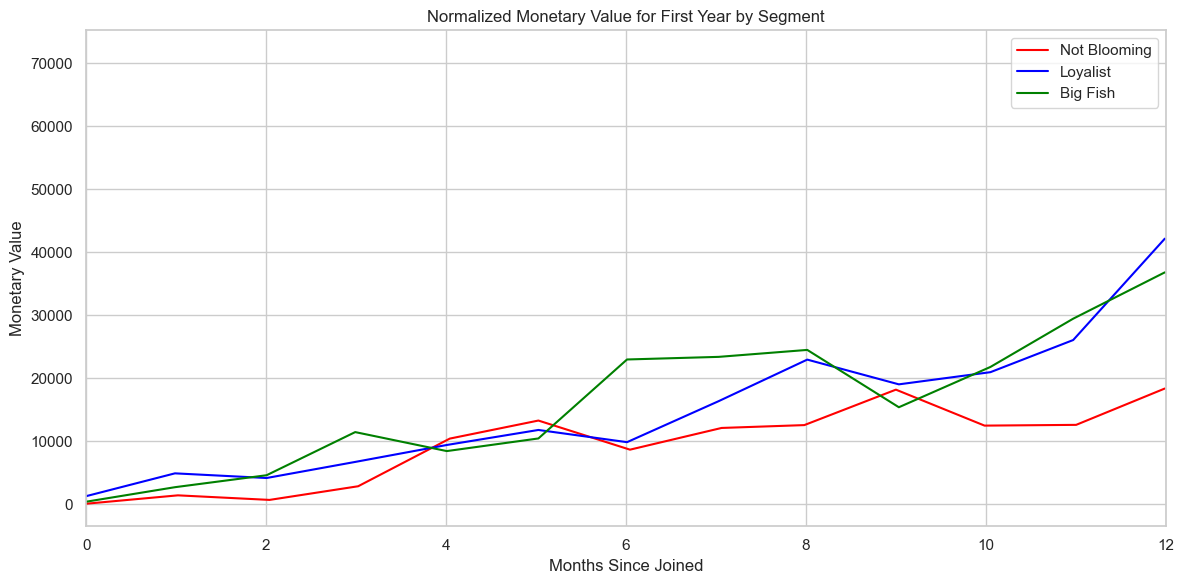

In [77]:
def preprocess(df, base_date):
    df['Month'] = pd.to_datetime(df['Month'])
    df['Months_Since_Joined'] = (df['Month'] - pd.to_datetime(base_date)) / np.timedelta64(1, 'M')
    max_monetary_value = df['Total_final_price'].max()
    df['Normalized_Monetary'] = df['Total_final_price'] / max_monetary_value
    return df

not_blooming_monetary = preprocess(not_blooming_monetary, '2022-06-30')
loyalist_monetary = preprocess(loyalist_monetary, '2021-03-31')
big_fish_monetary = preprocess(big_fish_monetary, '2021-03-31')

# Plotting
plt.figure(figsize=(12, 6))

#sns.lineplot(x=not_blooming_monetary['Months_Since_Joined'], y=not_blooming_monetary['Normalized_Monetary'], color='Red', label='Not Blooming')
#sns.lineplot(x=loyalist_monetary['Months_Since_Joined'], y=loyalist_monetary['Normalized_Monetary'], color='Blue', label='Loyalist')
#sns.lineplot(x=big_fish_monetary['Months_Since_Joined'], y=big_fish_monetary['Normalized_Monetary'], color='Green', label='Big Fish')

sns.lineplot(x=not_blooming_monetary['Months_Since_Joined'], y=not_blooming_monetary['Total_final_price'], color='Red', label='Not Blooming')
sns.lineplot(x=loyalist_monetary['Months_Since_Joined'], y=loyalist_monetary['Total_final_price'], color='Blue', label='Loyalist')
sns.lineplot(x=big_fish_monetary['Months_Since_Joined'], y=big_fish_monetary['Total_final_price'], color='Green', label='Big Fish')


plt.title('Normalized Monetary Value for First Year by Segment')
plt.xlabel('Months Since Joined')
plt.ylabel('Monetary Value')
plt.xlim(0, 12) 
plt.tight_layout()
plt.legend()
plt.show()

<Axes: xlabel='seg', ylabel='total_customers'>

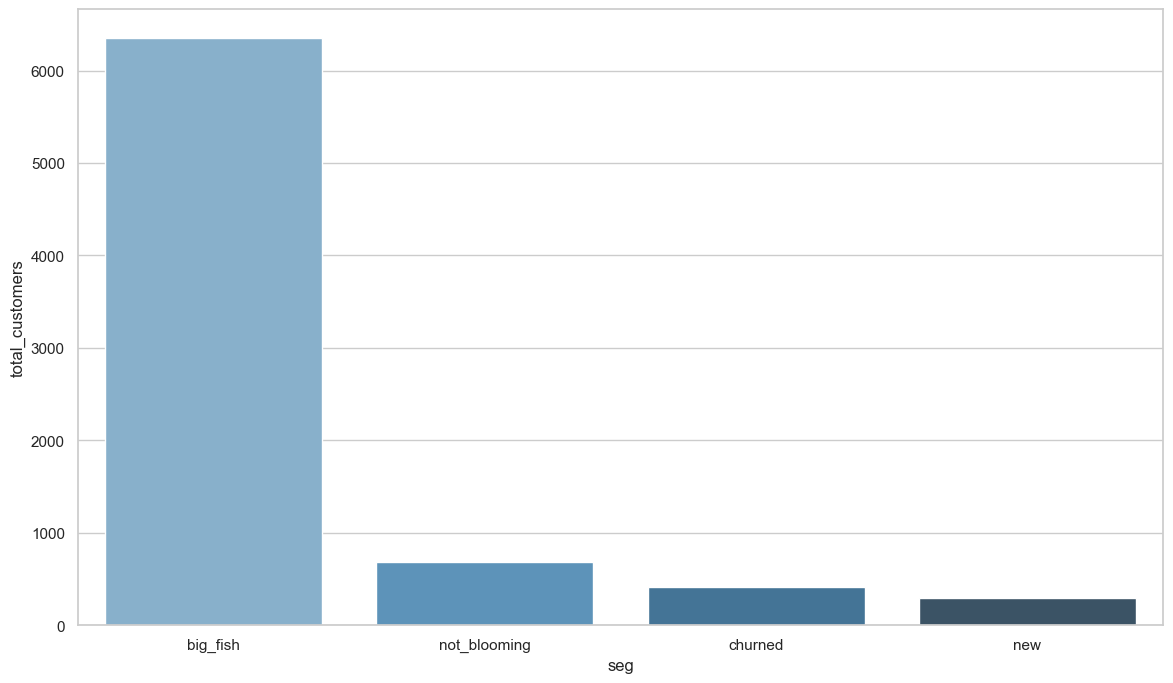

In [76]:
bar_rfm = rfm_by_full_name.groupby('seg')['total_customers'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(14,8))
bar_rfm.drop([0],inplace=True)
sns.barplot(data=bar_rfm,x='seg',y='total_customers',palette='Blues_d')